<a href="https://colab.research.google.com/github/JeanGrant/BSRV/blob/master/CafeTech%20CNN%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, shutil

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
main_path = '/content/drive/MyDrive/CafeTech Finalized Dataset/split_80-20/'
train_path = main_path + '/train'
test_path = main_path + '/test'

In [ ]:
path_files = []
path_labels = []
for i in range(5):
  if i == 0:
      current_class = 'healthy'
  elif i == 1:
      current_class = 'cercospora'
  elif i == 2:
      current_class = 'phoma'
  elif i == 3:
      current_class = 'rust'
  elif i == 4:
      current_class = 'miner'

  
  #Create a list of images per classification in the original directory
  images = sorted(os.listdir(train_path+'/'+current_class))
  print(current_class+': '+str(len(images)))

  for j in range(len(images)):
    path_files.append(train_path+'/'+current_class+'/'+images[j])
    path_labels.append(current_class)

training_set = 'training_set.csv'

df = pd.DataFrame()
df['labels']=[str(x) for x in path_labels]
df['images']=[str(x) for x in path_files]

df.to_csv(training_set, header=True, index=False)

healthy: 440
cercospora: 440
phoma: 440
rust: 440
miner: 440


In [ ]:
# training_set = train_path+'/training_set.csv'
train_data = pd.read_csv(training_set)
X = train_data['images']
Y = train_data['labels']

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   horizontal_flip = True,
                                   vertical_flip = True)
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
inception = InceptionV3(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in inception.layers:
  layer.trainable = False;

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
from sklearn.model_selection import KFold
num_folds = 5

checkpoint_filepath = 'inception_'
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=4)

In [ ]:
fold_no = 1
all_history = []

for train, test in kfold.split(X,Y):

  print('Fold: ' + str(fold_no))

  training_data = train_data.iloc[train]
  validation_data = train_data.iloc[test]

  training_set = train_datagen.flow_from_dataframe(training_data, directory = train_path, x_col='images', y_col='labels', 
                                                   target_size = (224, 224), batch_size = 16, class_mode = 'categorical', 
                                                   shuffle=True, validate_filenames=True)
  
  validation_set = validation_datagen.flow_from_dataframe(validation_data, directory = train_path, x_col='images', y_col='labels', 
                                                          target_size = (224, 224), batch_size = 16, class_mode = 'categorical', 
                                                          shuffle=False, validate_filenames=True)

  x = inception.output
  x = Flatten()(x)
  x = Dense(256, activation='relu')(x)
  x = Dense(128, activation='relu')(x)

  predictions = Dense(5, activation='softmax')(x)

  model = Model(inception.input, predictions)

  keras_callbacks   = [
        EarlyStopping(monitor='val_accuracy', patience=5, mode='max', min_delta=0.001),
        ModelCheckpoint(filepath=checkpoint_filepath+str(fold_no)+'.h5', monitor='val_accuracy', 
                        mode='max', save_best_only=True)]

  model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    optimizer =  tf.optimizers.SGD(learning_rate=0.001)
  )

  history = model.fit(
      training_set,
      validation_data=validation_set,
      epochs=50,
      batch_size=16,
      callbacks = keras_callbacks 
    )
  
  all_history.append(history)
  fold_no += 1

In [ ]:

for i in range(5):

  print('\n\n\nMatlab Plot of Fold No: ' + str(i))

  # plot the loss
  plt.title('Fold ' + str(i+1) + ': Loss vs Epoch')
  plt.plot(all_history[i].history['loss'], label='train loss')
  plt.plot(all_history[i].history['val_loss'], label='val loss')
  plt.legend()
  plt.show()

  # plot the accuracy
  plt.title('Fold ' + str(i+1) + ': Accuracy vs Epoch')
  plt.plot(all_history[i].history['accuracy'], label='train acc')
  plt.plot(all_history[i].history['val_accuracy'], label='val acc')
  plt.legend()
  plt.show()



In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 20,
                                            class_mode = 'categorical',
                                            shuffle=False)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
for i in range(5):
  model = load_model('inception_'+str(i+1)+'.h5')
      
  Y_pred = model.predict(test_set)
  y_pred = np.argmax(Y_pred, axis=1)
      
  print(classification_report(test_set.classes, y_pred))

  data = {'y_Actual':   test_set.classes,
            'y_Predicted':  y_pred
            }

  df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
  confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)

  sn.heatmap(confusion_matrix, annot=True, fmt='g')
  plt.show()

# **Pruning**

In [ ]:
pip install -q tensorflow-model-optimization

     |████████████████████████████████| 213 kB 4.2 MB/s 


In [ ]:
#load best model from KFold based on confusion matrix
model = load_model('/tmp/tmpizfwap5z_prune_constant 0.6 60endstep_3.h5')

In [ ]:
Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)
      
print(classification_report(test_set.classes, y_pred))

data = {'y_Actual':   test_set.classes,
            'y_Predicted':  y_pred
            }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)

sn.heatmap(confusion_matrix, annot=True, fmt='g')
plt.show()

In [ ]:
import tensorflow_model_optimization as tfmot

fold_no = 1
all_history = []

for train, test in kfold.split(X,Y):

  model = load_model('/content/drive/MyDrive/CafeTech Finalized Dataset/split_80-20/inception_3.h5')

  print('Fold: ' + str(fold_no))

  training_data = train_data.iloc[train]
  validation_data = train_data.iloc[test]

  training_set = train_datagen.flow_from_dataframe(training_data, directory = train_path,
                                                 x_col='images', y_col='labels',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical',
                                                 shuffle=True, validate_filenames=True)
  
  validation_set = validation_datagen.flow_from_dataframe(validation_data, directory = train_path,
                                                 x_col='images', y_col='labels',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical',
                                                 shuffle=False, validate_filenames=True)

  # Compute end step to finish pruning after 2 epochs.
  batch_size = 16
  epochs = 2
  validation_split = 0.2
  
  print(len(training_set.classes))

  num_images = len(training_set.classes)
  end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

  targetspars = 0.6
  beginstep_perc = 30
  beginstep = beginstep_perc/100

  new_pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=targetspars,
                                                   begin_step=beginstep*end_step,
                                                   end_step=end_step
                                                   )}

  inception_model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, **new_pruning_params)

  # Requirement for the inception_model_for_pruning
  import tempfile
  logdir = '/content/pruning_logs/' + str(fold_no) + '_'

  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  ]

  inception_model_for_pruning.compile(
      loss='categorical_crossentropy',
      optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
      metrics=['accuracy'])

  inception_model_for_pruning.fit(training_set,
              validation_data = validation_set,
              epochs = epochs,
              callbacks=[callbacks],
              batch_size=batch_size)

  inception_model_for_export = tfmot.sparsity.keras.strip_pruning(inception_model_for_pruning)

  _, inception_pruned_keras_file = tempfile.mkstemp('_prune_constant '+str(targetspars)+' '+str(beginstep_perc)+'endstep_'+str(fold_no)+'.h5')
  tf.keras.models.save_model(inception_model_for_export, inception_pruned_keras_file, include_optimizer=False)
  
  all_history.append(inception_model_for_pruning)
  fold_no += 1

In [ ]:
#load best model from KFold based on confusion matrix
model = load_model('/tmp/tmpbkx4kdc9_prune_constant 0.6 30endstep_1.h5')

              precision    recall  f1-score   support

           0       0.63      0.40      0.49       110
           1       0.77      0.75      0.76       110
           2       0.89      0.95      0.92       110
           3       0.75      0.67      0.71       110
           4       0.60      0.86      0.71       110

    accuracy                           0.73       550
   macro avg       0.73      0.73      0.72       550
weighted avg       0.73      0.73      0.72       550



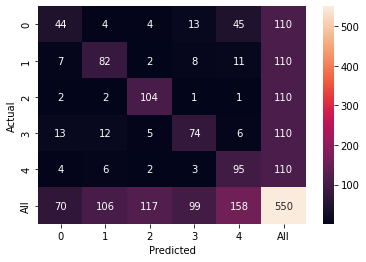

In [ ]:
Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)
      
print(classification_report(test_set.classes, y_pred))

data = {'y_Actual':   test_set.classes,
            'y_Predicted':  y_pred
            }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)

sn.heatmap(confusion_matrix, annot=True, fmt='g')
plt.show()

# **Conversion and Quantization**

In [ ]:
#load best model from KFold based on confusion matrix
model = load_model('inception_2.h5')

In [ ]:
!mkdir "tflite_models"

In [ ]:
TFLITE_QUANT_MODEL = "/content/tflite_models/inception_quant.tflite"

In [ ]:
run_model = tf.function(lambda x : model(x))

concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converted_tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(converted_tflite_quant_model)

print("TFLite models and their sizes:")
!ls "tflite_models" -lh